In [1]:
from transformers import AutoTokenizer, BertForQuestionAnswering, BertModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Load model and retrieve attention weights

from bertviz import head_view, model_view
# from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, BertForQuestionAnswering, AutoModel

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Getting Sentence embeddings from "all-mpnet-base-v2" and calculating cosine similarity

In [4]:
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
question = "he is a good man"
text = "he is a good man"
sentences = ["he is a good man", "he is a great man"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print('Sentence Embeddings:', sentence_embeddings)
print('Cosine Similarity from embeddings generated by the model: {:4f}'.format(torch.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0)).item()))

Sentence Embeddings: tensor([[ 0.0314,  0.0596,  0.0288,  ...,  0.0033,  0.0556,  0.0068],
        [ 0.0211,  0.0423,  0.0354,  ...,  0.0096,  0.0508, -0.0001]])
Cosine Similarity from embeddings generated by the model: 0.884947


### Visualising attentions in "all-mpnet-base-v2" while ignoring \<s\>

In [54]:
model_version = 'sentence-transformers/all-mpnet-base-v2'
model = AutoModel.from_pretrained(model_version, output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)

question = "he is a good man"
text = "What a great man he is"

inputs = tokenizer(question, text, return_tensors='pt')

input_ids = inputs['input_ids']
attention = model(input_ids)[-1]

input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [55]:
ticks = []
for j in range(len(inputs.input_ids)):
    print(f'Sentence {j+1}')
    for i in range(len(inputs.input_ids[j])):
        print(inputs.input_ids[0][i], ':', tokenizer.decode(inputs.input_ids[0][i]))
        ticks.append(tokenizer.decode(inputs.input_ids[0][i]))

Sentence 1
tensor(0) : <s>
tensor(2006) : he
tensor(2007) : is
tensor(1041) : a
tensor(2208) : good
tensor(2162) : man
tensor(2) : </s>
tensor(2) : </s>
tensor(2058) : what
tensor(1041) : a
tensor(2311) : great
tensor(2162) : man
tensor(2006) : he
tensor(2007) : is
tensor(2) : </s>


In [56]:
attention_tensors = []

for tensor in model(input_ids).attentions:
    attention_tensors.append(tensor.detach().numpy())

attentions_temp = torch.tensor(np.array(attention_tensors))
print(attentions_temp.shape)

torch.Size([12, 1, 12, 15, 15])


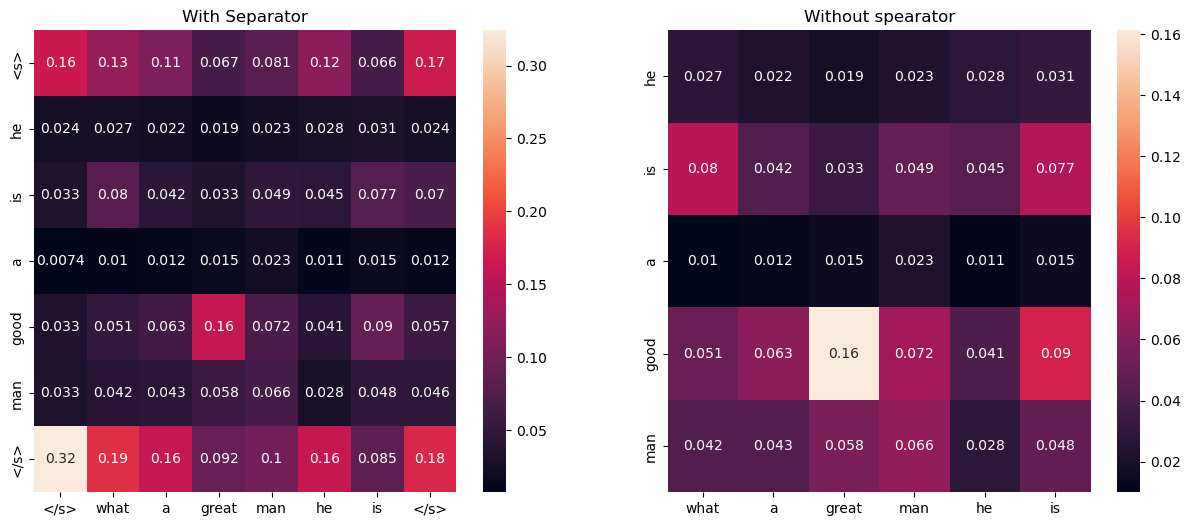

In [63]:
sentence1_len = len(question.split(" "))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("With Separator")
sns.heatmap(attentions_temp.mean(axis=2)[-1][0].T[0:sentence1_len+2,sentence1_len+2:] ,xticklabels = ticks[sentence1_len+2:] , yticklabels = ticks[0:sentence1_len+2], annot=True)
plt.subplot(1, 2, 2)
plt.title("Without spearator")
sns.heatmap(attentions_temp.mean(axis=2)[-1][0].T[1:sentence1_len+1,sentence1_len+3:-1] ,xticklabels = ticks[sentence1_len+3:-1] , yticklabels = ticks[1:sentence1_len+1], annot=True)
plt.show()

In [51]:
print(attentions_temp.mean(axis=2)[-2][0].T[1:sentence1_len+2,sentence1_len+2:])

tensor([[0.0495, 0.0069, 0.0364, 0.0109, 0.0073, 0.0220, 0.0167, 0.0038],
        [0.0397, 0.0079, 0.0137, 0.0069, 0.0073, 0.0095, 0.0226, 0.0027],
        [0.0122, 0.0018, 0.0127, 0.0031, 0.0026, 0.0034, 0.0070, 0.0014],
        [0.0324, 0.0072, 0.0224, 0.0164, 0.0094, 0.0076, 0.0218, 0.0013],
        [0.0510, 0.0106, 0.0323, 0.0135, 0.0337, 0.0105, 0.0178, 0.0019],
        [0.2947, 0.3844, 0.2296, 0.2716, 0.2734, 0.2783, 0.2035, 0.4903]])


In [52]:
tokenizer(question, text, return_tensors='pt')

{'input_ids': tensor([[   0, 2006, 2007, 1041, 2208, 2162,    2,    2, 2058, 1041, 2311, 2162,
         2006, 2007,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
 
 
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)
 
     # Get all hidden states
    states = output.hidden_states
     # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
     # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]
 
    return word_tokens_output.mean(dim=0)
 
 
def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
        that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
     # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
 
    return get_hidden_states(encoded, token_ids_word, model, layers)
 
 
def main(layers , sent1 , sent2):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

    sent1_embeddings = []
    sent2_embeddings = []
    sent1 = sent1
    sent2 = sent2
    for w in sent1.split(" "):
        sent1_embeddings.append(get_word_vector(sent1, get_word_idx(sent1, w), tokenizer, model, layers))
    for w in sent2.split(" "):
        sent2_embeddings.append(get_word_vector(sent2 , get_word_idx(sent2, w), tokenizer, model, layers))
    # idx = get_word_idx(sent, "cookies")

    # word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)
     
    return sent1_embeddings, sent2_embeddings 


In [ ]:
sent1 = question
sent2 = text
s1 , s2 = main(None , sent1 , sent2)
sentence1 = sent1.split(" ")
sentence2 = sent2.split(" ")
for idx1 , v1 in enumerate(s1):
    for idx2 , v2 in enumerate(s2):
        print('{} ~ {} ; Cosine Distance: {:5f}' .format(sentence1[idx1], sentence2[idx2], torch.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()))

he ~ he ; Cosine Distance: 1.000000
he ~ is ; Cosine Distance: 0.790254
he ~ a ; Cosine Distance: 0.717984
he ~ good ; Cosine Distance: 0.688151
he ~ man ; Cosine Distance: 0.763715
is ~ he ; Cosine Distance: 0.790254
is ~ is ; Cosine Distance: 1.000000
is ~ a ; Cosine Distance: 0.865570
is ~ good ; Cosine Distance: 0.786840
is ~ man ; Cosine Distance: 0.787070
a ~ he ; Cosine Distance: 0.717984
a ~ is ; Cosine Distance: 0.865570
a ~ a ; Cosine Distance: 1.000000
a ~ good ; Cosine Distance: 0.800178
a ~ man ; Cosine Distance: 0.746675
good ~ he ; Cosine Distance: 0.688151
good ~ is ; Cosine Distance: 0.786840
good ~ a ; Cosine Distance: 0.800178
good ~ good ; Cosine Distance: 1.000000
good ~ man ; Cosine Distance: 0.762201
man ~ he ; Cosine Distance: 0.763715
man ~ is ; Cosine Distance: 0.787070
man ~ a ; Cosine Distance: 0.746675
man ~ good ; Cosine Distance: 0.762201
man ~ man ; Cosine Distance: 1.000000


In [ ]:
attention_second_last = attentions_temp.mean(axis=2)[-2][0].T[1:sentence1_len+2,sentence1_len+2:] 
sum = 0
for r in range(attention_second_last.shape[0]-1):
    max_idx = np.argmax(attention_second_last[r])
    print(r , sentence1[r] , max_idx)
    if max_idx == len(attention_second_last[r])-1:
        continue
    print(sentence1[r] , sentence2[max_idx] , torch.cosine_similarity(s1[r].unsqueeze(0), s2[max_idx].unsqueeze(0)))
    sum+=torch.cosine_similarity(s1[r].unsqueeze(0), s2[max_idx].unsqueeze(0))


print(sum)
print(sum/len(question.split(" ")))

0 he tensor(5)
1 is tensor(5)
2 a tensor(1)
a is tensor([0.8656])
3 good tensor(1)
good is tensor([0.7868])
4 man tensor(5)
tensor([1.6524])
tensor([0.3305])
